In [1]:
# It is recommended to run this cell to ensure all dependencies are installed.
#!pip install torch torchaudio pandas numpy matplotlib seaborn librosa tqdm fastai

import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

from fastai.data.external import untar_data, URLs

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

In [2]:
import os
import random
import numpy as np

class CFG:
    # General
    SEED = 42
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Data
    DATA_PATH = f"C:\\Users\\sinha\\Downloads\\tsda_dataset-20251015T052020Z-1-001\\tsda_dataset"
    AUDIO_PATH = os.path.join(DATA_PATH, "audio")
    META_PATH = os.path.join(DATA_PATH, "meta/sound_50.csv")
    
    # Audio Preprocessing
    SAMPLING_RATE = 44100
    N_FFT = 2048
    WIN_LENGTH = 2048
    HOP_LENGTH = 512
    N_MELS = 128
    
    # Model & Training
    NUM_CLASSES = 50
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 1e-4

def set_seed(seed):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)   # <-- correct
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Make CuDNN deterministic (may slow training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Optional (PyTorch >=1.8) enforce deterministic algorithms
    # Disable strict deterministic algorithms (allows non-deterministic CuBLAS ops)
    try:
        torch.use_deterministic_algorithms(False)
    except Exception:
        pass
    
    # Also relax CuDNN settings so things run normally
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    
    print("Deterministic algorithms disabled. cudnn.deterministic =", torch.backends.cudnn.deterministic)

set_seed(CFG.SEED)
print(f"Using device: {CFG.DEVICE}")


Deterministic algorithms disabled. cudnn.deterministic = False
Using device: cuda


In [3]:
# Pre-create transforms so you don't recreate them every call
mel_transform = T.MelSpectrogram(
    sample_rate=CFG.SAMPLING_RATE,
    n_fft=CFG.N_FFT,
    win_length=CFG.WIN_LENGTH,
    hop_length=CFG.HOP_LENGTH,
    n_mels=CFG.N_MELS
)
db_transform = T.AmplitudeToDB()

In [4]:
# The following line is commented out as you have the dataset downloaded.
# Please ensure that the DATA_PATH in the CFG class above points to the correct directory.
# path = untar_data(URLs.ESC50, dest="ESC50")
# print(f"Dataset assumed to be at: {CFG.DATA_PATH}")

# Verify the contents
try:
    audio_files = os.listdir(CFG.AUDIO_PATH)
    print(f"Found {len(audio_files)} audio files in {CFG.AUDIO_PATH}")
    meta_files = os.listdir(os.path.join(CFG.DATA_PATH, "meta"))
    print(f"Found metadata files: {meta_files}")
except FileNotFoundError:
    print("Error: Dataset not found. Please check the DATA_PATH in the CFG class.")

Found 2000 audio files in C:\Users\sinha\Downloads\tsda_dataset-20251015T052020Z-1-001\tsda_dataset\audio
Found metadata files: ['sound_50.csv', 'sound_human_annotations.xlsx']


In [5]:
# Load the metadata CSV file
df = pd.read_csv(CFG.META_PATH)

# Display the first few rows to understand its structure
print("Metadata DataFrame Head:")
print(df.head())

# Display basic information about the dataframe
print("\nMetadata DataFrame Info:")
df.info()

# Check the distribution of classes
print(f"\nNumber of unique classes: {df['target'].nunique()}")
print(f"Number of examples per class:\n{df['category'].value_counts().head()}")

Metadata DataFrame Head:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Metadata DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   fold      2000 non-null   int64 
 2   target    2000 non-null   int64 
 3   category  2000 non-null   object
 4   esc10     2000 non-null   bool  
 5   src_file  2000 non-null   int64 
 6   take      2000 non-null   object
dtypes: bool(1), int64(3), object(3)
memory usage: 95.8+ KB

Nu

C:\Users\sinha\anaconda3\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


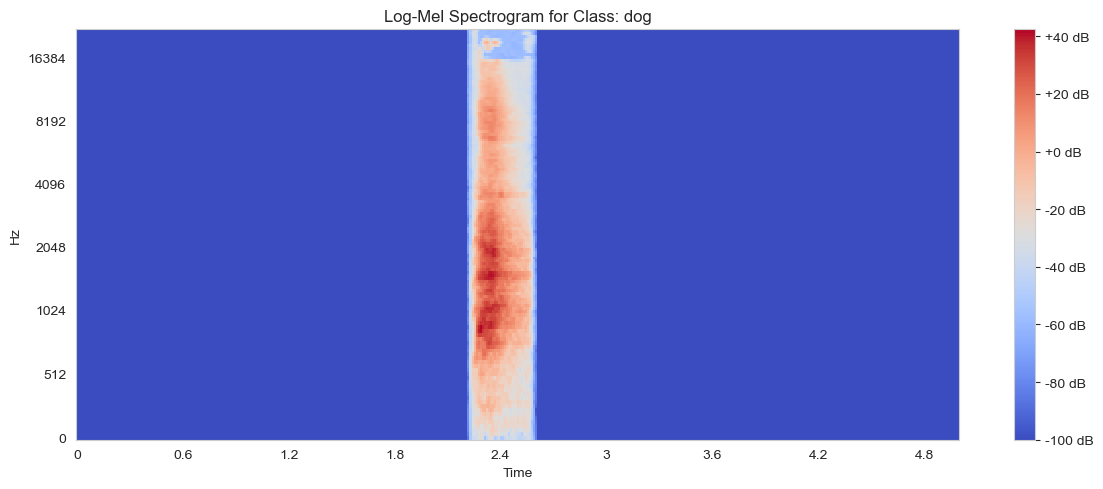

Spectrogram shape: torch.Size([1, 128, 431])


In [6]:
def get_mel_spectrogram(waveform):
    """
    Expects waveform tensor on CPU with shape [channels, samples] or [samples].
    Returns log-mel spectrogram tensor with shape [channels, n_mels, time].
    """
    # ensure channel dim exists
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)          # [1, samples]

    # mel_transform and db_transform are reused (precreated)
    mel_spec = mel_transform(waveform)           # -> [channels, n_mels, time]
    log_mel_spec = db_transform(mel_spec)
    return log_mel_spec

# pick one row correctly
sample_row = df.iloc[0]          # first row (or df.sample(1).iloc[0])

sample_path = os.path.join(CFG.AUDIO_PATH, sample_row['filename'])
waveform, sr = torchaudio.load(sample_path)   # waveform: [channels, samples] or [samples]

# Resample first if needed (torchaudio resampler handles multi-channel)
if sr != CFG.SAMPLING_RATE:
    waveform = T.Resample(sr, CFG.SAMPLING_RATE)(waveform)

# Convert to mono if multi-channel
if waveform.dim() == 2 and waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)   # -> [1, samples]

# Generate spectrogram (uses precreated transforms)
log_mel_spec = get_mel_spectrogram(waveform)       # [1, n_mels, time] typically

# Convert to numpy for librosa display:
# - squeeze only the channel dimension (squeeze(0)) so you don't accidentally drop n_mels if batch present
spec = log_mel_spec.squeeze(0).cpu().numpy()      # -> (n_mels, time)

plt.figure(figsize=(12, 5))
librosa.display.specshow(spec, sr=CFG.SAMPLING_RATE, hop_length=CFG.HOP_LENGTH,
                         x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
# guard the category field in case column name differs
title_cat = sample_row.get('category') if hasattr(sample_row, 'get') else sample_row['category']
plt.title(f"Log-Mel Spectrogram for Class: {title_cat}")
plt.tight_layout()
plt.show()

print(f"Spectrogram shape: {log_mel_spec.shape}")   # e.g. (1, n_mels, time)

In [7]:
class CRNN(nn.Module):
    def __init__(self, num_classes=CFG.NUM_CLASSES):
        super(CRNN, self).__init__()
        
        # Convolutional Blocks
        self.conv1 = self.conv_block(1, 32)
        self.conv2 = self.conv_block(32, 64)
        self.conv3 = self.conv_block(64, 128)
        self.conv4 = self.conv_block(128, 256)
        
        # Recurrent Layer (GRU)
        # The input feature size to the GRU is determined by the output of the CNN.
        # After conv4, the frequency dimension is reduced.
        # N_MELS -> 128 / 2 / 2 / 2 / 2 = 8.
        # So, the feature size is 256 * 8 = 2048.
        self.gru = nn.GRU(
            input_size=256 * 8, 
            hidden_size=128, 
            num_layers=2, 
            batch_first=True, 
            bidirectional=True,
            dropout=0.3
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 128),  # 128 * 2 because GRU is bidirectional
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        # x shape: (batch_size, 1, n_mels, time_steps)
        
        # Pass through convolutional blocks
        x = self.conv1(x)  # (B, 32, 64, T/2)
        x = self.conv2(x)  # (B, 64, 32, T/4)
        x = self.conv3(x)  # (B, 128, 16, T/8)
        x = self.conv4(x)  # (B, 256, 8, T/16)
        
        # The CNN-to-RNN Bridge: Reshape the output for the GRU
        # We want a sequence of shape (batch_size, seq_len, features)
        # Current shape: (B, Channels, Freq, Time)
        B, C, F, T = x.shape
        x = x.permute(0, 3, 1, 2)  # (B, Time, Channels, Freq)
        x = x.reshape(B, T, C * F)  # (B, T, Channels * Freq)
        
        # Pass through GRU
        self.gru.flatten_parameters() # For DataParallel compatibility
        x, _ = self.gru(x) # x shape: (B, T, hidden_size * 2)
        
        # We can use the output of the last time step for classification
        x = x[:, -1, :] # (B, hidden_size * 2)
        
        # Pass through the classifier
        x = self.classifier(x) # (B, num_classes)
        
        return x

# Instantiate the model to check its structure
model = CRNN(num_classes=CFG.NUM_CLASSES)
print(model)

CRNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d

In [8]:
class ESC50Dataset(Dataset):
    def __init__(self, df, data_path, fold_to_exclude, is_train=True, transform=None, augmentations=None):
        self.data_path = data_path
        if is_train:
            self.df = df[df['fold']!= fold_to_exclude].reset_index(drop=True)
        else:
            self.df = df[df['fold'] == fold_to_exclude].reset_index(drop=True)
            
        self.transform = transform
        self.augmentations = augmentations
        self.is_train = is_train
        self.target_length = 5 * CFG.SAMPLING_RATE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = os.path.join(self.data_path, row['filename'])
        
        # Load audio file
        waveform, sr = torchaudio.load(file_path)   # waveform: [channels, samples] or [samples]
        
        # Ensure channel dim exists: make shape [channels, samples]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)
        
        # Resample if necessary (Resample handles multi-channel)
        if sr != CFG.SAMPLING_RATE:
            waveform = T.Resample(sr, CFG.SAMPLING_RATE)(waveform)
        
        # Convert to mono if multi-channel
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)   # -> [1, samples]
        
        # Pad or truncate to fixed length (samples dimension is dim=1)
        n_samples = waveform.shape[1]
        if n_samples < self.target_length:
            pad_amount = self.target_length - n_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))  # pad last dim: (left, right)
        else:
            waveform = waveform[:, :self.target_length]
        
        # Apply spectrogram transform (waveform -> spectrogram)
        spectrogram = self.transform(waveform)   # expected shape: [channels, n_mels, time]
        
        # Optional augmentations on spectrogram (only for training)
        if self.is_train and (self.augmentations is not None):
            spectrogram = self.augmentations(spectrogram)
        
        label = torch.tensor(row['target'], dtype=torch.long)
        return spectrogram, label


In [9]:
# Define augmentations using torchaudio.transforms
# These will be applied only to the training data, on the spectrogram.
train_augmentations = nn.Sequential(
    T.TimeMasking(time_mask_param=80),
    T.FrequencyMasking(freq_mask_param=80)
)

In [10]:
# ADD (anywhere near imports)
class Compose:
    def __init__(self, transforms):
        self.transforms = list(transforms)
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x


In [11]:
# ADD / REPLACE
mel_transform = T.MelSpectrogram(
    sample_rate=CFG.SAMPLING_RATE,
    n_fft=CFG.N_FFT,
    win_length=CFG.WIN_LENGTH,
    hop_length=CFG.HOP_LENGTH,
    n_mels=CFG.N_MELS
)
db_transform = T.AmplitudeToDB()

# use Compose for train/val pipelines
train_spec_transform = Compose([mel_transform, db_transform])
val_spec_transform   = Compose([mel_transform, db_transform])


In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

# Main cross-validation loop
# Corrected cross-validation loop
fold_accuracies = []

for fold in range(1, 6):
    print(f"\n===== FOLD {fold} =====")
    
    # Create datasets and dataloaders (use train/val transforms)
    train_dataset = ESC50Dataset(df, CFG.AUDIO_PATH, fold_to_exclude=fold, is_train=True, 
                                 transform=train_spec_transform, augmentations=train_augmentations)
    val_dataset = ESC50Dataset(df, CFG.AUDIO_PATH, fold_to_exclude=fold, is_train=False, 
                               transform=val_spec_transform)
    
    # On Windows / notebooks, use num_workers=0 to avoid multiprocessing issues
    train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    
    # Initialize model, criterion, and optimizer
    model = CRNN(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)
    
    best_val_accuracy = 0.0
    best_model_path = f"best_model_fold_{fold}.pth"

    for epoch in range(CFG.EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, CFG.DEVICE)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, CFG.DEVICE)
        
        print(f"Epoch {epoch+1}/{CFG.EPOCHS} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> New best validation accuracy: {best_val_accuracy:.4f}. Model saved.")
            
    fold_accuracies.append(best_val_accuracy)
    print(f"Best validation accuracy for fold {fold}: {best_val_accuracy:.4f}")

print("All fold accuracies:", fold_accuracies)


===== FOLD 1 =====


Training:   0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\sinha\anaconda3\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 3.9030, Train Acc: 0.0300 | Val Loss: 3.8589, Val Acc: 0.0550
  -> New best validation accuracy: 0.0550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 3.8593, Train Acc: 0.0381 | Val Loss: 3.7989, Val Acc: 0.0600
  -> New best validation accuracy: 0.0600. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 3.7979, Train Acc: 0.0500 | Val Loss: 3.7277, Val Acc: 0.0800
  -> New best validation accuracy: 0.0800. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 3.7298, Train Acc: 0.0563 | Val Loss: 3.6522, Val Acc: 0.0850
  -> New best validation accuracy: 0.0850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 3.6577, Train Acc: 0.0688 | Val Loss: 3.5778, Val Acc: 0.1125
  -> New best validation accuracy: 0.1125. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 3.5869, Train Acc: 0.0775 | Val Loss: 3.4956, Val Acc: 0.1275
  -> New best validation accuracy: 0.1275. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 3.5229, Train Acc: 0.1013 | Val Loss: 3.4289, Val Acc: 0.1175


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 3.4483, Train Acc: 0.1094 | Val Loss: 3.3599, Val Acc: 0.1300
  -> New best validation accuracy: 0.1300. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 3.3749, Train Acc: 0.1144 | Val Loss: 3.2967, Val Acc: 0.1225


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 3.3109, Train Acc: 0.1275 | Val Loss: 3.2230, Val Acc: 0.1650
  -> New best validation accuracy: 0.1650. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 3.2688, Train Acc: 0.1462 | Val Loss: 3.1536, Val Acc: 0.1950
  -> New best validation accuracy: 0.1950. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 3.2117, Train Acc: 0.1419 | Val Loss: 3.0986, Val Acc: 0.2050
  -> New best validation accuracy: 0.2050. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 3.1286, Train Acc: 0.1550 | Val Loss: 3.0142, Val Acc: 0.2175
  -> New best validation accuracy: 0.2175. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 3.0677, Train Acc: 0.1731 | Val Loss: 2.9336, Val Acc: 0.2175


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 2.9950, Train Acc: 0.1888 | Val Loss: 2.8620, Val Acc: 0.2400
  -> New best validation accuracy: 0.2400. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 2.9151, Train Acc: 0.1925 | Val Loss: 2.7822, Val Acc: 0.2550
  -> New best validation accuracy: 0.2550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 2.8879, Train Acc: 0.2056 | Val Loss: 2.7600, Val Acc: 0.2450


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 2.8266, Train Acc: 0.2294 | Val Loss: 2.6564, Val Acc: 0.2950
  -> New best validation accuracy: 0.2950. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 2.7316, Train Acc: 0.2338 | Val Loss: 2.5832, Val Acc: 0.3100
  -> New best validation accuracy: 0.3100. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 2.6482, Train Acc: 0.2612 | Val Loss: 2.5220, Val Acc: 0.3425
  -> New best validation accuracy: 0.3425. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 2.5752, Train Acc: 0.2938 | Val Loss: 2.4482, Val Acc: 0.3500
  -> New best validation accuracy: 0.3500. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 2.5614, Train Acc: 0.2700 | Val Loss: 2.4041, Val Acc: 0.3425


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 2.4729, Train Acc: 0.2950 | Val Loss: 2.3912, Val Acc: 0.3375


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 2.4181, Train Acc: 0.3144 | Val Loss: 2.3061, Val Acc: 0.3850
  -> New best validation accuracy: 0.3850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 2.3723, Train Acc: 0.3275 | Val Loss: 2.3219, Val Acc: 0.3525


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 2.3146, Train Acc: 0.3400 | Val Loss: 2.1957, Val Acc: 0.3825


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 2.2616, Train Acc: 0.3500 | Val Loss: 2.1051, Val Acc: 0.3975
  -> New best validation accuracy: 0.3975. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 2.2165, Train Acc: 0.3556 | Val Loss: 2.0883, Val Acc: 0.4325
  -> New best validation accuracy: 0.4325. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 2.1310, Train Acc: 0.3781 | Val Loss: 2.0558, Val Acc: 0.4325


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 2.0990, Train Acc: 0.4088 | Val Loss: 1.9507, Val Acc: 0.4575
  -> New best validation accuracy: 0.4575. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 2.0451, Train Acc: 0.4094 | Val Loss: 1.9241, Val Acc: 0.4675
  -> New best validation accuracy: 0.4675. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 1.9898, Train Acc: 0.4275 | Val Loss: 1.9500, Val Acc: 0.4525


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 1.9088, Train Acc: 0.4537 | Val Loss: 1.8107, Val Acc: 0.4850
  -> New best validation accuracy: 0.4850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 1.8740, Train Acc: 0.4581 | Val Loss: 1.9214, Val Acc: 0.4450


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.8924, Train Acc: 0.4481 | Val Loss: 1.7762, Val Acc: 0.5250
  -> New best validation accuracy: 0.5250. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.8300, Train Acc: 0.4856 | Val Loss: 1.8196, Val Acc: 0.4775


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.7965, Train Acc: 0.4744 | Val Loss: 1.7958, Val Acc: 0.4875


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 1.7013, Train Acc: 0.5050 | Val Loss: 1.7559, Val Acc: 0.5150


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 1.6988, Train Acc: 0.4819 | Val Loss: 1.6649, Val Acc: 0.5300
  -> New best validation accuracy: 0.5300. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 1.6678, Train Acc: 0.5169 | Val Loss: 1.6721, Val Acc: 0.5275


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 1.6563, Train Acc: 0.5088 | Val Loss: 1.6706, Val Acc: 0.5450
  -> New best validation accuracy: 0.5450. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 1.5741, Train Acc: 0.5487 | Val Loss: 1.7908, Val Acc: 0.4875


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 1.5251, Train Acc: 0.5581 | Val Loss: 1.6444, Val Acc: 0.5125


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 1.5431, Train Acc: 0.5369 | Val Loss: 1.5843, Val Acc: 0.5375


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 1.5190, Train Acc: 0.5587 | Val Loss: 1.7485, Val Acc: 0.5075


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 1.4574, Train Acc: 0.5750 | Val Loss: 1.5637, Val Acc: 0.5600
  -> New best validation accuracy: 0.5600. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 1.4369, Train Acc: 0.5650 | Val Loss: 1.6264, Val Acc: 0.5375


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 1.3994, Train Acc: 0.5913 | Val Loss: 1.4841, Val Acc: 0.5775
  -> New best validation accuracy: 0.5775. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 1.3526, Train Acc: 0.5938 | Val Loss: 1.5453, Val Acc: 0.5375


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 1.3264, Train Acc: 0.6112 | Val Loss: 1.5215, Val Acc: 0.5375
Best validation accuracy for fold 1: 0.5775

===== FOLD 2 =====


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 3.9036, Train Acc: 0.0244 | Val Loss: 3.8601, Val Acc: 0.0575
  -> New best validation accuracy: 0.0575. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 3.8618, Train Acc: 0.0425 | Val Loss: 3.8037, Val Acc: 0.0475


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 3.7987, Train Acc: 0.0631 | Val Loss: 3.7369, Val Acc: 0.0575


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 3.7468, Train Acc: 0.0700 | Val Loss: 3.6592, Val Acc: 0.0700
  -> New best validation accuracy: 0.0700. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 3.6679, Train Acc: 0.0675 | Val Loss: 3.5897, Val Acc: 0.0875
  -> New best validation accuracy: 0.0875. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 3.6137, Train Acc: 0.0638 | Val Loss: 3.5238, Val Acc: 0.1050
  -> New best validation accuracy: 0.1050. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 3.5541, Train Acc: 0.0813 | Val Loss: 3.4512, Val Acc: 0.1075
  -> New best validation accuracy: 0.1075. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 3.4635, Train Acc: 0.0994 | Val Loss: 3.3850, Val Acc: 0.1425
  -> New best validation accuracy: 0.1425. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 3.4155, Train Acc: 0.0963 | Val Loss: 3.3373, Val Acc: 0.1575
  -> New best validation accuracy: 0.1575. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 3.3325, Train Acc: 0.1269 | Val Loss: 3.2582, Val Acc: 0.1825
  -> New best validation accuracy: 0.1825. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 3.2444, Train Acc: 0.1325 | Val Loss: 3.1763, Val Acc: 0.2075
  -> New best validation accuracy: 0.2075. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 3.2004, Train Acc: 0.1450 | Val Loss: 3.1266, Val Acc: 0.1875


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 3.1548, Train Acc: 0.1450 | Val Loss: 3.0644, Val Acc: 0.2275
  -> New best validation accuracy: 0.2275. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 3.0770, Train Acc: 0.1656 | Val Loss: 2.9628, Val Acc: 0.2550
  -> New best validation accuracy: 0.2550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 2.9964, Train Acc: 0.1875 | Val Loss: 2.9276, Val Acc: 0.2575
  -> New best validation accuracy: 0.2575. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 2.9525, Train Acc: 0.1900 | Val Loss: 2.8482, Val Acc: 0.2525


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 2.8514, Train Acc: 0.2125 | Val Loss: 2.7682, Val Acc: 0.2775
  -> New best validation accuracy: 0.2775. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 2.8004, Train Acc: 0.2200 | Val Loss: 2.6950, Val Acc: 0.3075
  -> New best validation accuracy: 0.3075. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 2.7366, Train Acc: 0.2350 | Val Loss: 2.6644, Val Acc: 0.2975


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 2.6942, Train Acc: 0.2437 | Val Loss: 2.5615, Val Acc: 0.3375
  -> New best validation accuracy: 0.3375. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 2.6235, Train Acc: 0.2444 | Val Loss: 2.5318, Val Acc: 0.3150


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 2.5129, Train Acc: 0.2863 | Val Loss: 2.5268, Val Acc: 0.3075


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 2.4992, Train Acc: 0.2831 | Val Loss: 2.5429, Val Acc: 0.3175


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 2.4659, Train Acc: 0.2931 | Val Loss: 2.4001, Val Acc: 0.3450
  -> New best validation accuracy: 0.3450. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 2.4052, Train Acc: 0.3013 | Val Loss: 2.3752, Val Acc: 0.3300


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 2.3143, Train Acc: 0.3412 | Val Loss: 2.2675, Val Acc: 0.4100
  -> New best validation accuracy: 0.4100. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 2.2402, Train Acc: 0.3488 | Val Loss: 2.2591, Val Acc: 0.3850


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 2.2404, Train Acc: 0.3400 | Val Loss: 2.2056, Val Acc: 0.4100


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 2.1053, Train Acc: 0.3794 | Val Loss: 2.1264, Val Acc: 0.4650
  -> New best validation accuracy: 0.4650. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 2.1262, Train Acc: 0.3931 | Val Loss: 2.0788, Val Acc: 0.4475


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 2.0693, Train Acc: 0.3987 | Val Loss: 2.0784, Val Acc: 0.4525


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 2.0063, Train Acc: 0.3994 | Val Loss: 2.0764, Val Acc: 0.4575


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 1.9656, Train Acc: 0.4213 | Val Loss: 1.9887, Val Acc: 0.4700
  -> New best validation accuracy: 0.4700. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 1.8747, Train Acc: 0.4450 | Val Loss: 1.9339, Val Acc: 0.5125
  -> New best validation accuracy: 0.5125. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.8253, Train Acc: 0.4587 | Val Loss: 1.9361, Val Acc: 0.5050


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.8133, Train Acc: 0.4681 | Val Loss: 1.8877, Val Acc: 0.5125


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.7944, Train Acc: 0.4437 | Val Loss: 1.8983, Val Acc: 0.5050


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 1.7101, Train Acc: 0.4888 | Val Loss: 1.7838, Val Acc: 0.5675
  -> New best validation accuracy: 0.5675. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 1.6924, Train Acc: 0.5006 | Val Loss: 1.8017, Val Acc: 0.5525


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 1.6738, Train Acc: 0.4944 | Val Loss: 1.7324, Val Acc: 0.5600


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 1.6128, Train Acc: 0.5200 | Val Loss: 1.6429, Val Acc: 0.5975
  -> New best validation accuracy: 0.5975. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 1.5557, Train Acc: 0.5350 | Val Loss: 1.7622, Val Acc: 0.5375


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 1.4928, Train Acc: 0.5519 | Val Loss: 1.7744, Val Acc: 0.5075


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 1.4767, Train Acc: 0.5787 | Val Loss: 1.6855, Val Acc: 0.5625


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 1.4052, Train Acc: 0.5794 | Val Loss: 1.6370, Val Acc: 0.5750


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 1.4235, Train Acc: 0.5656 | Val Loss: 1.5789, Val Acc: 0.6100
  -> New best validation accuracy: 0.6100. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 1.4306, Train Acc: 0.5706 | Val Loss: 1.5227, Val Acc: 0.6175
  -> New best validation accuracy: 0.6175. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 1.3692, Train Acc: 0.5956 | Val Loss: 1.5790, Val Acc: 0.6000


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 1.3419, Train Acc: 0.5881 | Val Loss: 1.4975, Val Acc: 0.5900


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 1.2875, Train Acc: 0.6219 | Val Loss: 1.6039, Val Acc: 0.6075
Best validation accuracy for fold 2: 0.6175

===== FOLD 3 =====


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 3.9035, Train Acc: 0.0213 | Val Loss: 3.8647, Val Acc: 0.0250
  -> New best validation accuracy: 0.0250. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 3.8588, Train Acc: 0.0394 | Val Loss: 3.7975, Val Acc: 0.0475
  -> New best validation accuracy: 0.0475. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 3.7999, Train Acc: 0.0550 | Val Loss: 3.7303, Val Acc: 0.0650
  -> New best validation accuracy: 0.0650. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 3.7344, Train Acc: 0.0600 | Val Loss: 3.6452, Val Acc: 0.0825
  -> New best validation accuracy: 0.0825. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 3.6602, Train Acc: 0.0663 | Val Loss: 3.5690, Val Acc: 0.0800


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 3.5925, Train Acc: 0.0800 | Val Loss: 3.4963, Val Acc: 0.1175
  -> New best validation accuracy: 0.1175. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 3.5299, Train Acc: 0.0938 | Val Loss: 3.4151, Val Acc: 0.1425
  -> New best validation accuracy: 0.1425. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 3.4567, Train Acc: 0.0969 | Val Loss: 3.3427, Val Acc: 0.1450
  -> New best validation accuracy: 0.1450. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 3.3780, Train Acc: 0.1062 | Val Loss: 3.2705, Val Acc: 0.1550
  -> New best validation accuracy: 0.1550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 3.3137, Train Acc: 0.1450 | Val Loss: 3.1825, Val Acc: 0.1975
  -> New best validation accuracy: 0.1975. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 3.2582, Train Acc: 0.1263 | Val Loss: 3.1297, Val Acc: 0.1750


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 3.1838, Train Acc: 0.1550 | Val Loss: 3.1151, Val Acc: 0.2125
  -> New best validation accuracy: 0.2125. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 3.1497, Train Acc: 0.1581 | Val Loss: 2.9520, Val Acc: 0.2350
  -> New best validation accuracy: 0.2350. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 3.0588, Train Acc: 0.1744 | Val Loss: 2.8890, Val Acc: 0.2675
  -> New best validation accuracy: 0.2675. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 2.9950, Train Acc: 0.1812 | Val Loss: 2.8086, Val Acc: 0.2825
  -> New best validation accuracy: 0.2825. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 2.9375, Train Acc: 0.1881 | Val Loss: 2.8113, Val Acc: 0.2500


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 2.8819, Train Acc: 0.2069 | Val Loss: 2.6795, Val Acc: 0.2850
  -> New best validation accuracy: 0.2850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 2.5876, Train Acc: 0.2612 | Val Loss: 2.3283, Val Acc: 0.3750
  -> New best validation accuracy: 0.3750. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 2.4988, Train Acc: 0.2956 | Val Loss: 2.3865, Val Acc: 0.3500


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 2.4726, Train Acc: 0.3094 | Val Loss: 2.2857, Val Acc: 0.4100
  -> New best validation accuracy: 0.4100. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 2.3820, Train Acc: 0.3312 | Val Loss: 2.1480, Val Acc: 0.4100


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 2.3461, Train Acc: 0.3481 | Val Loss: 2.0989, Val Acc: 0.4475
  -> New best validation accuracy: 0.4475. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 2.2494, Train Acc: 0.3531 | Val Loss: 2.0728, Val Acc: 0.4650
  -> New best validation accuracy: 0.4650. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 2.2519, Train Acc: 0.3631 | Val Loss: 1.9858, Val Acc: 0.4775
  -> New best validation accuracy: 0.4775. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 2.1771, Train Acc: 0.3750 | Val Loss: 1.9762, Val Acc: 0.4700


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 2.1486, Train Acc: 0.3769 | Val Loss: 1.9714, Val Acc: 0.4750


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 2.0714, Train Acc: 0.4100 | Val Loss: 1.8623, Val Acc: 0.5000
  -> New best validation accuracy: 0.5000. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 2.0429, Train Acc: 0.4094 | Val Loss: 1.8447, Val Acc: 0.5125
  -> New best validation accuracy: 0.5125. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 2.0035, Train Acc: 0.4219 | Val Loss: 1.8571, Val Acc: 0.4925


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 1.9375, Train Acc: 0.4313 | Val Loss: 1.7837, Val Acc: 0.5025


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.9011, Train Acc: 0.4556 | Val Loss: 1.7733, Val Acc: 0.5025


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.8787, Train Acc: 0.4562 | Val Loss: 1.7056, Val Acc: 0.5275
  -> New best validation accuracy: 0.5275. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.8241, Train Acc: 0.4750 | Val Loss: 1.6715, Val Acc: 0.5500
  -> New best validation accuracy: 0.5500. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 1.7790, Train Acc: 0.4831 | Val Loss: 1.6379, Val Acc: 0.5550
  -> New best validation accuracy: 0.5550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 1.7438, Train Acc: 0.4825 | Val Loss: 1.6501, Val Acc: 0.5275


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 1.6993, Train Acc: 0.5069 | Val Loss: 1.6188, Val Acc: 0.5300


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 1.6226, Train Acc: 0.5250 | Val Loss: 1.5583, Val Acc: 0.5500


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 1.5631, Train Acc: 0.5419 | Val Loss: 1.5445, Val Acc: 0.5750
  -> New best validation accuracy: 0.5750. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 1.5886, Train Acc: 0.5325 | Val Loss: 1.5433, Val Acc: 0.5550


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 1.5808, Train Acc: 0.5312 | Val Loss: 1.5560, Val Acc: 0.5550


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 1.4875, Train Acc: 0.5800 | Val Loss: 1.4970, Val Acc: 0.5650


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 1.4884, Train Acc: 0.5587 | Val Loss: 1.4879, Val Acc: 0.5850
  -> New best validation accuracy: 0.5850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 1.4449, Train Acc: 0.5800 | Val Loss: 1.4651, Val Acc: 0.5875
  -> New best validation accuracy: 0.5875. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 1.3968, Train Acc: 0.5956 | Val Loss: 1.4184, Val Acc: 0.5925
  -> New best validation accuracy: 0.5925. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 1.3689, Train Acc: 0.6056 | Val Loss: 1.3641, Val Acc: 0.6150
  -> New best validation accuracy: 0.6150. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 1.3993, Train Acc: 0.5863 | Val Loss: 1.4036, Val Acc: 0.5825
Best validation accuracy for fold 3: 0.6150

===== FOLD 4 =====


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 3.9012, Train Acc: 0.0294 | Val Loss: 3.8570, Val Acc: 0.0550
  -> New best validation accuracy: 0.0550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 3.8569, Train Acc: 0.0400 | Val Loss: 3.7911, Val Acc: 0.0850
  -> New best validation accuracy: 0.0850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 3.7946, Train Acc: 0.0656 | Val Loss: 3.7158, Val Acc: 0.1150
  -> New best validation accuracy: 0.1150. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 3.7452, Train Acc: 0.0525 | Val Loss: 3.6316, Val Acc: 0.0975


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 3.6702, Train Acc: 0.0663 | Val Loss: 3.5407, Val Acc: 0.1075


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 3.6063, Train Acc: 0.0712 | Val Loss: 3.4576, Val Acc: 0.1175
  -> New best validation accuracy: 0.1175. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 3.5247, Train Acc: 0.0919 | Val Loss: 3.3679, Val Acc: 0.1550
  -> New best validation accuracy: 0.1550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 3.4501, Train Acc: 0.1081 | Val Loss: 3.2930, Val Acc: 0.1500


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 3.3967, Train Acc: 0.1044 | Val Loss: 3.2224, Val Acc: 0.2050
  -> New best validation accuracy: 0.2050. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 3.3302, Train Acc: 0.1163 | Val Loss: 3.1325, Val Acc: 0.2100
  -> New best validation accuracy: 0.2100. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 3.2726, Train Acc: 0.1344 | Val Loss: 3.0658, Val Acc: 0.2200
  -> New best validation accuracy: 0.2200. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 3.2149, Train Acc: 0.1394 | Val Loss: 2.9892, Val Acc: 0.2275
  -> New best validation accuracy: 0.2275. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 3.1609, Train Acc: 0.1450 | Val Loss: 2.8943, Val Acc: 0.2425
  -> New best validation accuracy: 0.2425. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 3.0573, Train Acc: 0.1713 | Val Loss: 2.8053, Val Acc: 0.2550
  -> New best validation accuracy: 0.2550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 3.0026, Train Acc: 0.1638 | Val Loss: 2.7612, Val Acc: 0.2550


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 2.9594, Train Acc: 0.1837 | Val Loss: 2.6672, Val Acc: 0.2900
  -> New best validation accuracy: 0.2900. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 2.8479, Train Acc: 0.2050 | Val Loss: 2.6174, Val Acc: 0.2725


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 2.7890, Train Acc: 0.2263 | Val Loss: 2.5514, Val Acc: 0.2975
  -> New best validation accuracy: 0.2975. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 2.7571, Train Acc: 0.2131 | Val Loss: 2.4813, Val Acc: 0.3175
  -> New best validation accuracy: 0.3175. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 2.6932, Train Acc: 0.2394 | Val Loss: 2.4685, Val Acc: 0.3225
  -> New best validation accuracy: 0.3225. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 2.6514, Train Acc: 0.2387 | Val Loss: 2.4323, Val Acc: 0.3375
  -> New best validation accuracy: 0.3375. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 2.5749, Train Acc: 0.2550 | Val Loss: 2.3449, Val Acc: 0.3450
  -> New best validation accuracy: 0.3450. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 2.5155, Train Acc: 0.2844 | Val Loss: 2.2782, Val Acc: 0.3700
  -> New best validation accuracy: 0.3700. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 2.4969, Train Acc: 0.2775 | Val Loss: 2.2871, Val Acc: 0.3850
  -> New best validation accuracy: 0.3850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 2.4127, Train Acc: 0.3019 | Val Loss: 2.1840, Val Acc: 0.3875
  -> New best validation accuracy: 0.3875. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 2.3697, Train Acc: 0.3144 | Val Loss: 2.1887, Val Acc: 0.3975
  -> New best validation accuracy: 0.3975. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 2.3112, Train Acc: 0.3237 | Val Loss: 2.1496, Val Acc: 0.3975


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 2.2556, Train Acc: 0.3581 | Val Loss: 2.1497, Val Acc: 0.4000
  -> New best validation accuracy: 0.4000. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 2.2447, Train Acc: 0.3438 | Val Loss: 2.0423, Val Acc: 0.4250
  -> New best validation accuracy: 0.4250. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 2.1127, Train Acc: 0.3894 | Val Loss: 2.0012, Val Acc: 0.4625
  -> New best validation accuracy: 0.4625. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 2.1519, Train Acc: 0.3613 | Val Loss: 1.9978, Val Acc: 0.4400


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 2.0790, Train Acc: 0.3950 | Val Loss: 1.9733, Val Acc: 0.4450


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 2.0777, Train Acc: 0.3925 | Val Loss: 1.8801, Val Acc: 0.4675
  -> New best validation accuracy: 0.4675. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 2.0239, Train Acc: 0.4075 | Val Loss: 1.8091, Val Acc: 0.4700
  -> New best validation accuracy: 0.4700. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.9842, Train Acc: 0.4037 | Val Loss: 1.7587, Val Acc: 0.5175
  -> New best validation accuracy: 0.5175. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.8997, Train Acc: 0.4506 | Val Loss: 1.8134, Val Acc: 0.4875


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.8271, Train Acc: 0.4637 | Val Loss: 1.7490, Val Acc: 0.4875


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 1.8073, Train Acc: 0.4806 | Val Loss: 1.7767, Val Acc: 0.4925


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 1.7606, Train Acc: 0.4744 | Val Loss: 1.6655, Val Acc: 0.5400
  -> New best validation accuracy: 0.5400. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 1.7543, Train Acc: 0.4906 | Val Loss: 1.7196, Val Acc: 0.5050


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 1.7023, Train Acc: 0.4850 | Val Loss: 1.6284, Val Acc: 0.5400


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 1.6906, Train Acc: 0.4850 | Val Loss: 1.6768, Val Acc: 0.5350


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 1.6214, Train Acc: 0.5119 | Val Loss: 1.5417, Val Acc: 0.5425
  -> New best validation accuracy: 0.5425. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 1.5858, Train Acc: 0.5244 | Val Loss: 1.6597, Val Acc: 0.5400


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 1.5723, Train Acc: 0.5281 | Val Loss: 1.5494, Val Acc: 0.5400


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 1.5844, Train Acc: 0.5350 | Val Loss: 1.5918, Val Acc: 0.5425


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 1.4553, Train Acc: 0.5656 | Val Loss: 1.5023, Val Acc: 0.5675
  -> New best validation accuracy: 0.5675. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 1.4792, Train Acc: 0.5531 | Val Loss: 1.4973, Val Acc: 0.5475


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 1.4631, Train Acc: 0.5425 | Val Loss: 1.5342, Val Acc: 0.5400


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 1.3902, Train Acc: 0.5881 | Val Loss: 1.5471, Val Acc: 0.5425
Best validation accuracy for fold 4: 0.5675

===== FOLD 5 =====


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 3.8955, Train Acc: 0.0338 | Val Loss: 3.8487, Val Acc: 0.0550
  -> New best validation accuracy: 0.0550. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 3.8385, Train Acc: 0.0425 | Val Loss: 3.7773, Val Acc: 0.0725
  -> New best validation accuracy: 0.0725. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 3.7773, Train Acc: 0.0531 | Val Loss: 3.7008, Val Acc: 0.0875
  -> New best validation accuracy: 0.0875. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 3.7077, Train Acc: 0.0700 | Val Loss: 3.6170, Val Acc: 0.1150
  -> New best validation accuracy: 0.1150. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 3.6322, Train Acc: 0.0906 | Val Loss: 3.5449, Val Acc: 0.1125


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 3.5656, Train Acc: 0.0825 | Val Loss: 3.4693, Val Acc: 0.1225
  -> New best validation accuracy: 0.1225. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 3.4913, Train Acc: 0.0938 | Val Loss: 3.3908, Val Acc: 0.1275
  -> New best validation accuracy: 0.1275. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 3.4051, Train Acc: 0.1075 | Val Loss: 3.3246, Val Acc: 0.1650
  -> New best validation accuracy: 0.1650. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 3.3386, Train Acc: 0.1237 | Val Loss: 3.2445, Val Acc: 0.1775
  -> New best validation accuracy: 0.1775. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 3.3042, Train Acc: 0.1394 | Val Loss: 3.1776, Val Acc: 0.1650


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 3.2289, Train Acc: 0.1369 | Val Loss: 3.1197, Val Acc: 0.1900
  -> New best validation accuracy: 0.1900. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 3.1445, Train Acc: 0.1425 | Val Loss: 3.0408, Val Acc: 0.2225
  -> New best validation accuracy: 0.2225. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 3.0998, Train Acc: 0.1556 | Val Loss: 3.0290, Val Acc: 0.2075


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 3.0743, Train Acc: 0.1456 | Val Loss: 2.9300, Val Acc: 0.2325
  -> New best validation accuracy: 0.2325. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 2.9790, Train Acc: 0.1731 | Val Loss: 2.8618, Val Acc: 0.2325


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 2.9082, Train Acc: 0.1850 | Val Loss: 2.7953, Val Acc: 0.2575
  -> New best validation accuracy: 0.2575. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 2.8527, Train Acc: 0.2056 | Val Loss: 2.7786, Val Acc: 0.2750
  -> New best validation accuracy: 0.2750. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 2.7590, Train Acc: 0.2188 | Val Loss: 2.7165, Val Acc: 0.3000
  -> New best validation accuracy: 0.3000. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 2.7626, Train Acc: 0.2106 | Val Loss: 2.6620, Val Acc: 0.3050
  -> New best validation accuracy: 0.3050. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 2.6757, Train Acc: 0.2481 | Val Loss: 2.5745, Val Acc: 0.3225
  -> New best validation accuracy: 0.3225. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 2.6063, Train Acc: 0.2444 | Val Loss: 2.5793, Val Acc: 0.3250
  -> New best validation accuracy: 0.3250. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 2.5403, Train Acc: 0.2706 | Val Loss: 2.4699, Val Acc: 0.3600
  -> New best validation accuracy: 0.3600. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 2.5069, Train Acc: 0.2681 | Val Loss: 2.4680, Val Acc: 0.3200


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 2.4437, Train Acc: 0.2838 | Val Loss: 2.4311, Val Acc: 0.3550


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 2.3811, Train Acc: 0.3125 | Val Loss: 2.3151, Val Acc: 0.3750
  -> New best validation accuracy: 0.3750. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 2.3408, Train Acc: 0.3150 | Val Loss: 2.2853, Val Acc: 0.3950
  -> New best validation accuracy: 0.3950. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 2.2890, Train Acc: 0.3231 | Val Loss: 2.2511, Val Acc: 0.4075
  -> New best validation accuracy: 0.4075. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 2.1947, Train Acc: 0.3463 | Val Loss: 2.2672, Val Acc: 0.3700


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 2.1931, Train Acc: 0.3713 | Val Loss: 2.1960, Val Acc: 0.3875


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 2.1717, Train Acc: 0.3713 | Val Loss: 2.1194, Val Acc: 0.4300
  -> New best validation accuracy: 0.4300. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 2.0682, Train Acc: 0.4025 | Val Loss: 2.1144, Val Acc: 0.4350
  -> New best validation accuracy: 0.4350. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 1.9882, Train Acc: 0.4175 | Val Loss: 2.0296, Val Acc: 0.4200


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 2.0150, Train Acc: 0.4062 | Val Loss: 1.9957, Val Acc: 0.4375
  -> New best validation accuracy: 0.4375. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 1.9576, Train Acc: 0.4175 | Val Loss: 1.9229, Val Acc: 0.4725
  -> New best validation accuracy: 0.4725. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 1.8753, Train Acc: 0.4437 | Val Loss: 1.9678, Val Acc: 0.4850
  -> New best validation accuracy: 0.4850. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 1.8345, Train Acc: 0.4556 | Val Loss: 1.8375, Val Acc: 0.5050
  -> New best validation accuracy: 0.5050. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 1.8176, Train Acc: 0.4594 | Val Loss: 1.8764, Val Acc: 0.4675


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 1.7692, Train Acc: 0.4738 | Val Loss: 1.8177, Val Acc: 0.4925


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 1.7405, Train Acc: 0.4919 | Val Loss: 1.7284, Val Acc: 0.5250
  -> New best validation accuracy: 0.5250. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 1.6859, Train Acc: 0.4988 | Val Loss: 1.7538, Val Acc: 0.5175


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 1.6563, Train Acc: 0.5119 | Val Loss: 1.7035, Val Acc: 0.5300
  -> New best validation accuracy: 0.5300. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 1.6126, Train Acc: 0.5200 | Val Loss: 1.6701, Val Acc: 0.5300


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 1.5540, Train Acc: 0.5381 | Val Loss: 1.6936, Val Acc: 0.5350
  -> New best validation accuracy: 0.5350. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 1.5466, Train Acc: 0.5437 | Val Loss: 1.6750, Val Acc: 0.5600
  -> New best validation accuracy: 0.5600. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 1.4610, Train Acc: 0.5625 | Val Loss: 1.6362, Val Acc: 0.5575


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 1.4388, Train Acc: 0.5831 | Val Loss: 1.6077, Val Acc: 0.5350


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 1.4153, Train Acc: 0.5850 | Val Loss: 1.5545, Val Acc: 0.5700
  -> New best validation accuracy: 0.5700. Model saved.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 1.3807, Train Acc: 0.5969 | Val Loss: 1.5521, Val Acc: 0.5625


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 1.4097, Train Acc: 0.5919 | Val Loss: 1.5715, Val Acc: 0.5575


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 1.3328, Train Acc: 0.6131 | Val Loss: 1.5477, Val Acc: 0.5700
Best validation accuracy for fold 5: 0.5700
All fold accuracies: [0.5775, 0.6175, 0.615, 0.5675, 0.57]


In [13]:
mean_accuracy = np.mean(fold_accuracies)
print(f"Mean accuracy across folds: {mean_accuracy:.4f}")

Mean accuracy across folds: 0.5895
